In [2]:
from mobilib.utils.models import train_test_split
from mobilib.models.data_windowing import WindowGenerator
from mobilib import Trajectory
from mobilib import constants
from sklearn import metrics
import pandas as pd
import numpy as np
import mobilib
import warnings

warnings.filterwarnings("ignore")

### Trajectory Classification

In [2]:
raw_data = pd.read_csv('./test.csv')

In [3]:
traj = Trajectory(df=raw_data, x='x', y='y', t='datetime', uid='id', is_latlng=True)

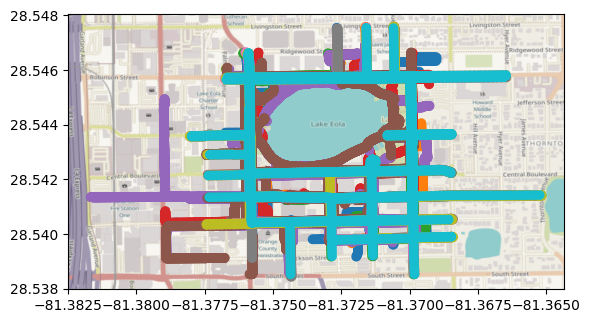

In [4]:
mobilib.image.plot(traj, ax=traj.gdf.plot(column=constants.UID))

In [5]:
from mobilib.models.classifier import TrajDeepFeedForward
from mobilib.utils.model_selection import train_test_split

In [6]:
# Split traj data in train and test
train, test = train_test_split(traj)
# Split train data in train and validation
train, val = train_test_split(train)

In [7]:
# Define features and label
features :[str]= ['speed', 'angle']
label :str= 'stop'

In [8]:
train_X, train_y = train.gdf[features], train.gdf[label]
val_X, val_y = val.gdf[features], val.gdf[label]
test_X, test_y = test.gdf[features], test.gdf[label]

In [9]:
tdff = TrajDeepFeedForward(train_X.shape[-1], 1)
class_weight = {False: 0.5, True: 1}
tdff.compile()
tdff.fit(train_X, train_y, val_X, val_y, class_weight=class_weight)


Epoch 1/30

15/15 - 2s - loss: 0.9389 - accuracy: 0.0147 - precision: 0.0317 - recall: 0.0472 - val_loss: 0.2039 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 2s/epoch - 135ms/step
Epoch 2/30
15/15 - 0s - loss: 0.2724 - accuracy: 0.0000e+00 - precision: 0.0303 - recall: 0.0524 - val_loss: 0.2016 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 391ms/epoch - 26ms/step
Epoch 3/30
15/15 - 0s - loss: 0.1682 - accuracy: 0.0000e+00 - precision: 0.0457 - recall: 0.0301 - val_loss: 0.1881 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 458ms/epoch - 31ms/step
Epoch 4/30
15/15 - 0s - loss: 0.1304 - accuracy: 0.0000e+00 - precision: 0.0769 - recall: 0.0079 - val_loss: 0.2233 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - 329ms/epoch - 22ms/step
Epoch 5/30
15/15 - 0s - loss: 0.1066 - accuracy: 0.0000e+00 - precision: 0.1339 - recall: 0.0223 - val_loss: 0.1079 

In [10]:
pred_y = tdff.predict(test_X)
test_y = np.asarray(test_y).astype(bool)

ac = metrics.accuracy_score(test_y, pred_y)
pr = metrics.precision_score(test_y, pred_y)
pe = metrics.recall_score(test_y, pred_y)
f1 = metrics.f1_score(test_y, pred_y)
print(f'Accuracy: {ac}')
print(f'Precision: {pr}')
print(f'Recall: {pe}')
print(f'F1: {f1}')

909/909 [==============================] - 2s 2ms/step
Accuracy: 0.2181555502046713
Precision: 0.03837366728718904
Recall: 1.0
F1: 0.07391109481318503


### Trajectory Prediction

In [9]:
# before make a class for the library,
# let's write a straight code

In [87]:
# take one example out of the dataset
raw_data = pd.read_csv('./test.csv')
example_date = raw_data[raw_data['id'] == raw_data['id'].unique()[0]]
traj = Trajectory(example_date, x='x', y='y', t='datetime', uid='id', is_latlng=True)

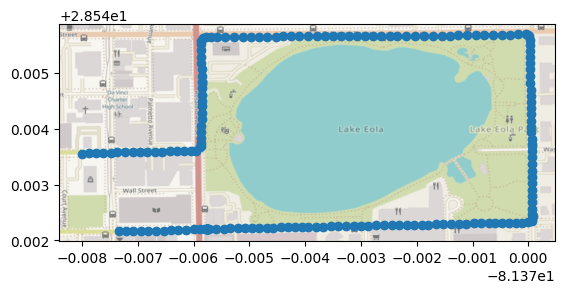

In [88]:
mobilib.image.plot(traj)

In [89]:
train, test = train_test_split(traj, test_size=0.2)
test, val = train_test_split(test, test_size=0.5)

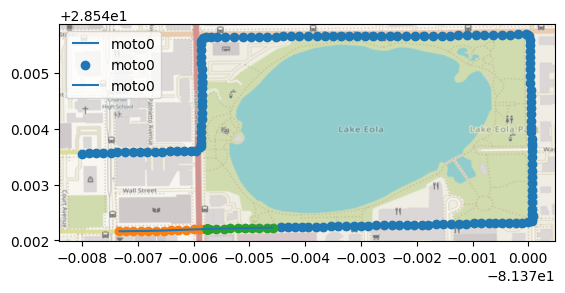

In [90]:
mobilib.image.plot([train, val, test])

In [91]:
features :[str]= ['speed', 'stop', 'timestep', 'angle', constants.LATITUDE]
labels :[str]= ['speed']

In [92]:
train_df = train.gdf[features]
val_df = val.gdf[features]
test_df = test.gdf[features]

In [93]:
len(train_df), len(val_df), len(test_df)

(148, 19, 19)

In [94]:
input_width = 2
OUT_STEPS = 2
window_generator = WindowGenerator(input_width, OUT_STEPS, OUT_STEPS, train_df, val_df, test_df, labels)

In [95]:
from mobilib.models.prediction import TrajLSTM
traj_lstm = TrajLSTM()
traj_lstm.compile_and_fit(window_generator)

Epoch 1/100
5/5 [==============================] - 4s 166ms/step - loss: 150.4623 - mean_absolute_error: 11.9775 - val_loss: 101.3271 - val_mean_absolute_error: 8.7842
Epoch 2/100
5/5 [==============================] - 0s 25ms/step - loss: 135.6290 - mean_absolute_error: 11.3430 - val_loss: 91.9009 - val_mean_absolute_error: 8.4627
Epoch 3/100
5/5 [==============================] - 0s 21ms/step - loss: 122.2577 - mean_absolute_error: 10.7431 - val_loss: 82.0228 - val_mean_absolute_error: 8.0863
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 110.4826 - mean_absolute_error: 10.1766 - val_loss: 73.1330 - val_mean_absolute_error: 7.7289
Epoch 5/100
5/5 [==============================] - 0s 23ms/step - loss: 97.7787 - mean_absolute_error: 9.5292 - val_loss: 64.2068 - val_mean_absolute_error: 7.3395
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 85.1775 - mean_absolute_error: 8.8564 - val_loss: 57.7567 - val_mean_absolute_error: 7.0558
Epoch 

In [96]:
val_perf = traj_lstm.evaluate(window_generator.val)
performace = traj_lstm.evaluate(window_generator.test, verbose=0)

1/1 [==============================] - 0s 86ms/step - loss: 30.8246 - mean_absolute_error: 4.7824


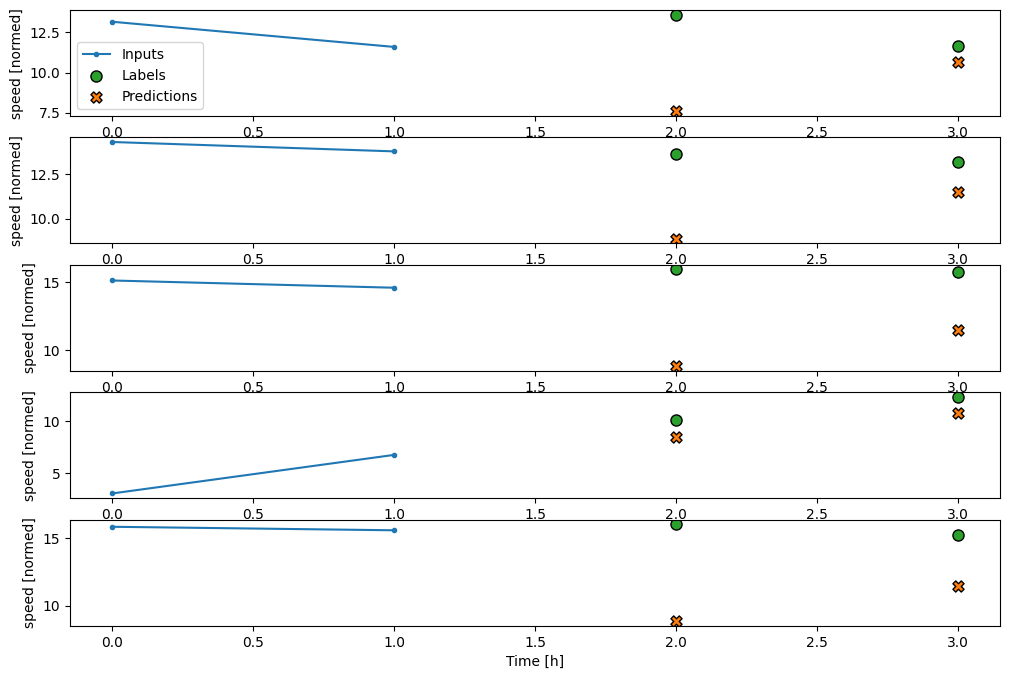

In [97]:
window_generator.plot(traj_lstm.lstm, plot_col='speed', max_subplots=5)